<a href="https://colab.research.google.com/github/cdavidrios/TDS1_Espacios_Representacion/blob/main/Espacios_de_representacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Espacios de representación (aplicaciones)

Autores

* Daniel Escobar Grisales
* Cristian David Rios Urrego
* Juan Rafael Orozco Arroyave


## Introducción

En el procesamiento de señales, los espacios de representación permiten describir una señal a través de un conjunto de características relevantes que resumen su información esencial.
Este tipo de representaciones son la base de muchas aplicaciones modernas como el reconocimiento de voz, la identificación de hablantes, la detección de emociones, e incluso el análisis de música y sonidos ambientales.

Más detalles pueden ser consultados en el siguiente recurso: <font color='red'>[Acá va la URL del HTML espacios de representación]</font>

En esta guía exploraremos cómo construir y analizar un espacio de representación acústico a partir de señales de voz.
Para ello utilizaremos la base de datos RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song), que contiene grabaciones de actores expresando diferentes emociones.
Nos enfocaremos en comparar grabaciones emociones como alegría de emociones como enojo, y veremos cómo estas diferencias se reflejan en el espacio de representación obtenido mediante coeficientes MFCC (Mel Frequency Cepstral Coefficients).


In [23]:
import os
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io.wavfile import read, write # libreria para lectura de archivos de audio
from IPython.display import Audio # para escuchar la senal
from scipy.fftpack import dct
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [24]:
def compute_mel_coefficients(segm, fs, NFFT, sample_hop, number_coefficients, n_mels = 128 ):

    mel_spectrogram = librosa.feature.melspectrogram(y = segm, sr= fs, n_fft=NFFT, hop_length=sample_hop, n_mels = n_mels)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram)
    # Aplicar la DCT a cada columna del espectrograma Mel para obtener los coeficientes
    dct_spectrogram = dct(mel_spectrogram_db, type=2, axis=-2, norm='ortho')

    # Seleccionar los primeros M coeficientes
    coefficients = dct_spectrogram[:number_coefficients, :]

    # Para obtener una representación final, sumar los coeficientes a lo largo del tiempo para cada banda
    final_coefficients = np.sum(coefficients, axis=1)

    # Imprimir los coeficientes finales

    return mel_spectrogram, mel_spectrogram_db, dct_spectrogram, coefficients, final_coefficients

def plot_mfccs_process(x, fs, NFFT, hop_length, n_mels, n_mfccs):
    mel_spectrogram, mel_spectrogram_db, dct_spectrogram, target_coeffients, MFCCs_a = compute_mel_coefficients(x, fs, NFFT, hop_length, n_mfccs, n_mels = n_mels )
    plt.figure(figsize=(25,5))
    plt.suptitle(clase, fontsize=18)
    plt.subplot(141)
    plt.title('Señal de audio')
    plt.plot(x)
    plt.subplot(142)
    plt.title('Mel spectrogram')
    librosa.display.specshow(mel_spectrogram_db, sr=fs, x_axis='time', y_axis='mel', cmap=None, hop_length=hop_length)#ax.set_ylim(0, 4000)
    plt.subplot(143)
    plt.title('Cepstral over time representation')
    librosa.display.specshow(dct_spectrogram, sr=fs, x_axis='time', y_axis=None, cmap=None, hop_length=hop_length)#ax.set_ylim(0, 4000)
    plt.yticks(np.arange(0, n_mels+10, 10), [f'Cep-{i}' for i in np.arange(1, n_mels+10, 10)])
    plt.subplot(144)
    plt.title('MFCCs over time representation')
    librosa.display.specshow(target_coeffients, sr=fs, x_axis='time', cmap=None, hop_length=hop_length)
    plt.yticks(np.arange(n_mfccs), [f'Cep-{i}' for i in range(1, n_mfccs+1)])
    plt.show()

def plot_espectrograms(x, fs, NFFT, hop_length, n_mels, n_mfccs):
    mel_spectrogram, mel_spectrogram_db, dct_spectrogram, target_coeffients, MFCCs_a = compute_mel_coefficients(x, fs, NFFT, hop_length, n_mfccs, n_mels = n_mels )
    plt.figure(figsize=(25,5))
    librosa.display.specshow(mel_spectrogram_db, sr=fs, x_axis='time', y_axis='mel', cmap=None, hop_length=hop_length)
    plt.title('Mel spectrogram ' + clase)
    plt.xlabel('Tiempo')
    plt.ylabel('Amplitud')
    plt.show()

## Grabaciones originales

Antes de extraer características, escuchemos algunos ejemplos de las dos emociones que analizaremos.
En esta base de datos, los actores pronuncian la misma frase, pero modifican su entonación y expresión vocal para transmitir distintas emociones.

### Dominio temporal

En el dominio temporal, las señales pueden parecer similares: comparten duración, estructura silábica y ritmo.
Sin embargo, las diferencias emocionales como la energía, la velocidad o el tono se reflejan en patrones más sutiles que no siempre son evidentes a simple vista en la forma de onda.

Por esta razón, necesitaremos transformar la señal hacia otros espacios de representación, donde esas diferencias se vuelvan más claras y cuantificables.

Ejemplo de audio feliz


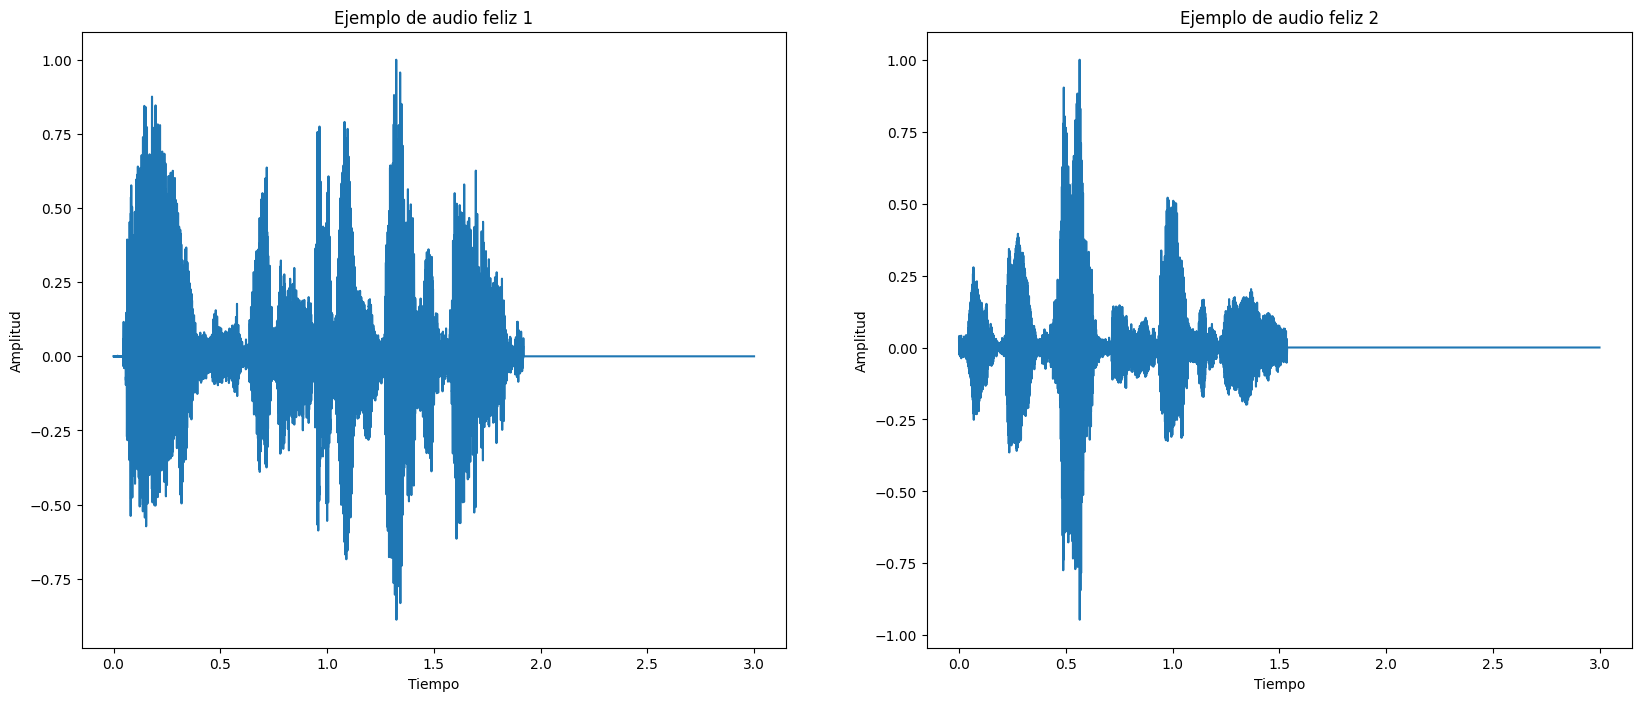

In [25]:
from IPython.display import Audio, display

PATH_PRE = 'Data/'
folder = os.path.join(PATH_PRE, 'Happy')

file = os.listdir(folder)[0]
fs, x=read(folder + '/' + file)
x1 = x/max(x) - np.mean(x)
t1 = np.arange(0, len(x)/fs, 1/fs)

file = os.listdir(folder)[3]
fs, x=read(folder + '/' + file)
x2 = x/max(x) - np.mean(x)
t2 = np.arange(0, len(x2)/fs, 1/fs)

plt.figure(figsize = (20,8))
plt.subplot(121)
plt.plot(t1,x1)
plt.title('Ejemplo de audio feliz 1')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.subplot(122)
plt.plot(t2,x2)
plt.title('Ejemplo de audio feliz 2')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')



print('Ejemplo de audio feliz')
Audio(x2, rate=fs) # para escuchar la senal, si se dese




Ejemplo de audio enojado


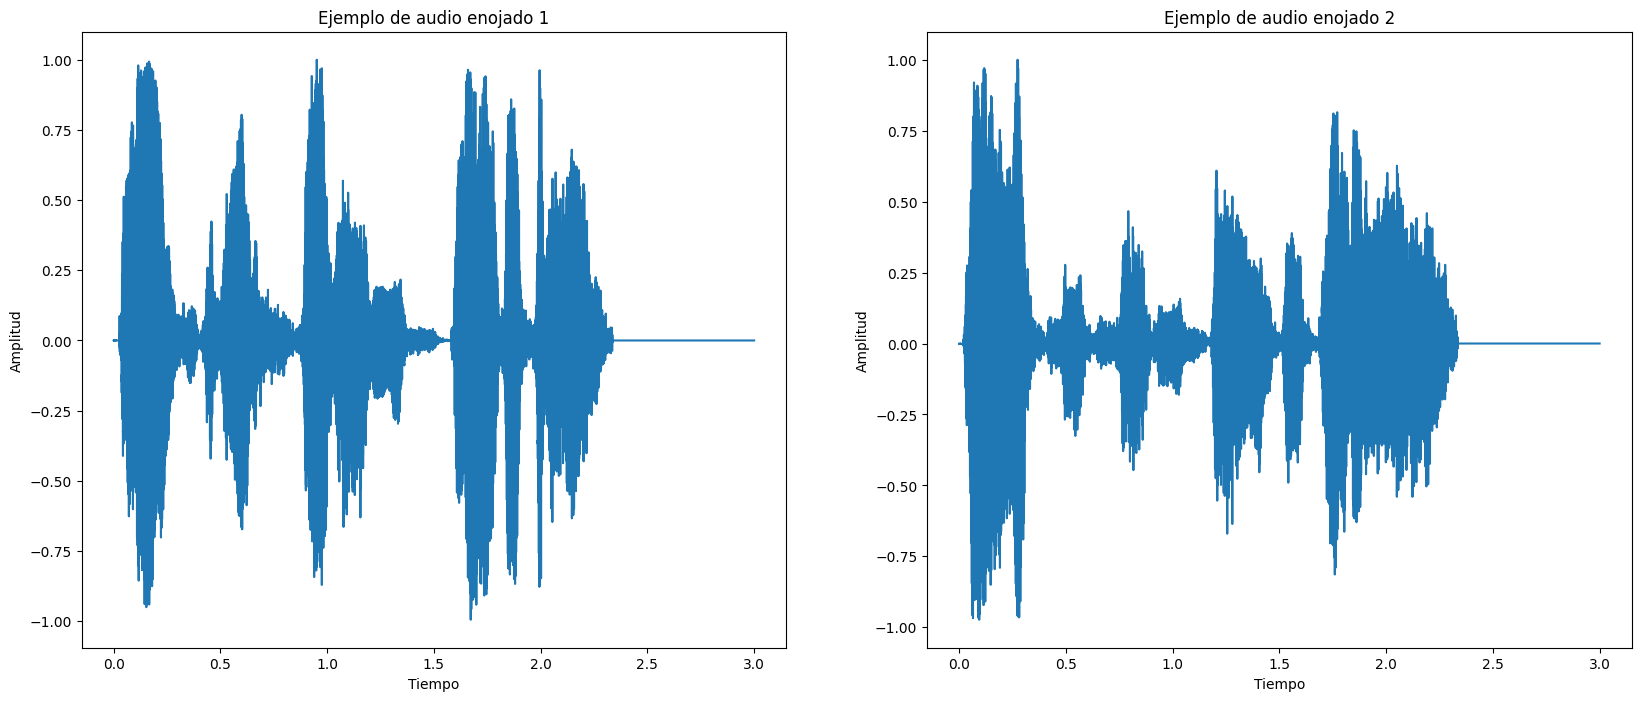

In [26]:
folder = os.path.join(PATH_PRE, 'Angry')

file = os.listdir(folder)[0]
fs, x=read(folder + '/' + file)
x1 = x/max(x) - np.mean(x)
t1 = np.arange(0, len(x)/fs, 1/fs)

file = os.listdir(folder)[1]
fs, x=read(folder + '/' + file)
x2 = x/max(x) - np.mean(x)
t2 = np.arange(0, len(x)/fs, 1/fs)

plt.figure(figsize = (20,8))
plt.subplot(121)
plt.plot(t1,x1)
plt.title('Ejemplo de audio enojado 1')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.subplot(122)
plt.plot(t2,x2)
plt.title('Ejemplo de audio enojado 2')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')



print('Ejemplo de audio enojado')
Audio(x2, rate=fs) # para escuchar la senal, si se dese

### Dominio espectral

Mientras que el dominio temporal muestra cómo varía la amplitud de la señal de voz a lo largo del tiempo, el dominio espectral permite analizar cómo se distribuye la energía en las distintas frecuencias, revelando características que no son visibles en la forma de onda.
En particular, al comparar las emociones de enojo y felicidad, el dominio espectral muestra diferencias claras: ambas suelen presentar alta energía global y un rango de frecuencias amplio, pero el enojo tiende a concentrar más energía en las frecuencias medias y altas, con transiciones más bruscas y patrones más irregulares, mientras que la felicidad suele presentar un espectro más equilibrado, con variaciones más suaves y una distribución armónica más estable.
Estas diferencias espectrales reflejan matices en la entonación y el timbre que resultan esenciales para distinguir entre ambas emociones, y que no pueden apreciarse fácilmente en el dominio temporal.

Un espectrograma es una representación visual que muestra cómo la energía de una señal se distribuye en el tiempo y la frecuencia, permitiendo observar su contenido espectral de forma dinámica.



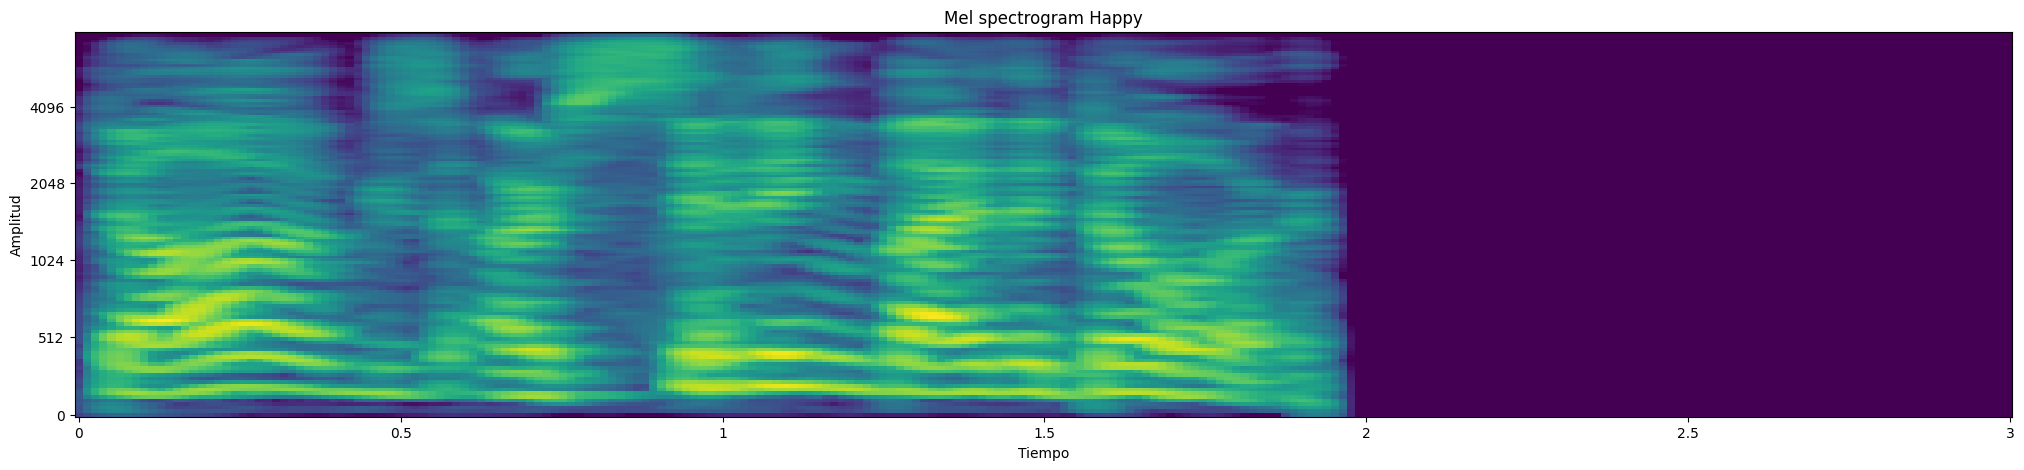

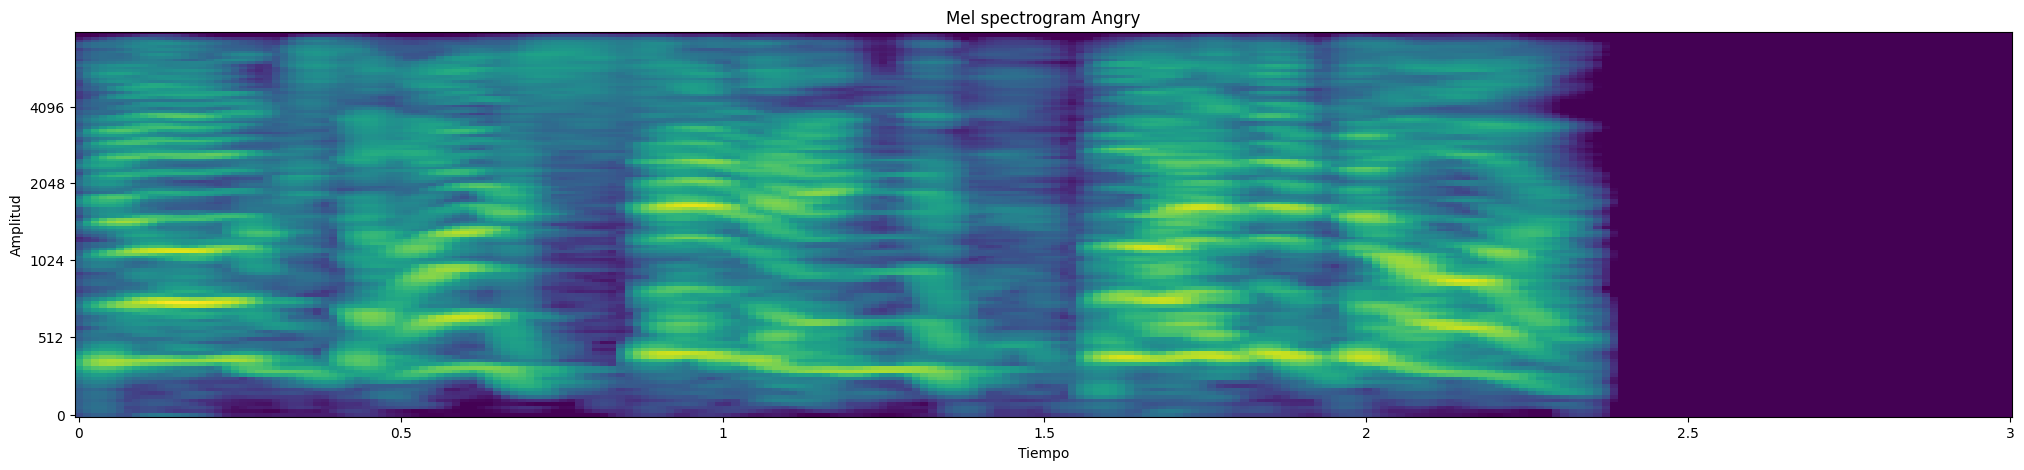

In [27]:
PATH_PRE = 'Data/'

NFFT = 2048
hop_length = NFFT//10
n_mels = 128
n_mfccs = 13

for i,clase in enumerate(os.listdir(PATH_PRE)):
    folder = os.path.join(PATH_PRE, clase)
    try:
      file = os.listdir(folder)[0]
      x, fs = librosa.load(os.path.join(folder, file), sr=16000)
      plot_espectrograms(x, fs, NFFT, hop_length, n_mels, n_mfccs)
    except:
      None

In [28]:
os.listdir(PATH_PRE)

['Happy', '.ipynb_checkpoints', 'Angry']

### Espacios de representación (MFCCs)

A partir del espectrograma en escala Mel que simula la manera en que el oído humano percibe las frecuencias: con mayor resolución en las bandas bajas y menor en las altas.
La energía filtrada en cada una de estas bandas se transforma luego mediante una Transformada Discreta del Coseno (DCT), lo que genera los Coeficientes Cepstrales en Escala Mel (MFCCs).
Estos coeficientes describen la envolvente espectral de la señal y condensan su información acústica en un conjunto compacto de valores que reflejan su timbre y estructura perceptual.

En la figura puede observarse esta progresión:
de la forma de onda original, pasamos al espectrograma en escala de Mel, el calculo de la DCT y finalmente al mapa de MFCCs tomando solo los primeros 13 coeficientes. Esté será nuestro un espacio de representación más abstracto y adecuado para tareas como la clasificación de emociones.

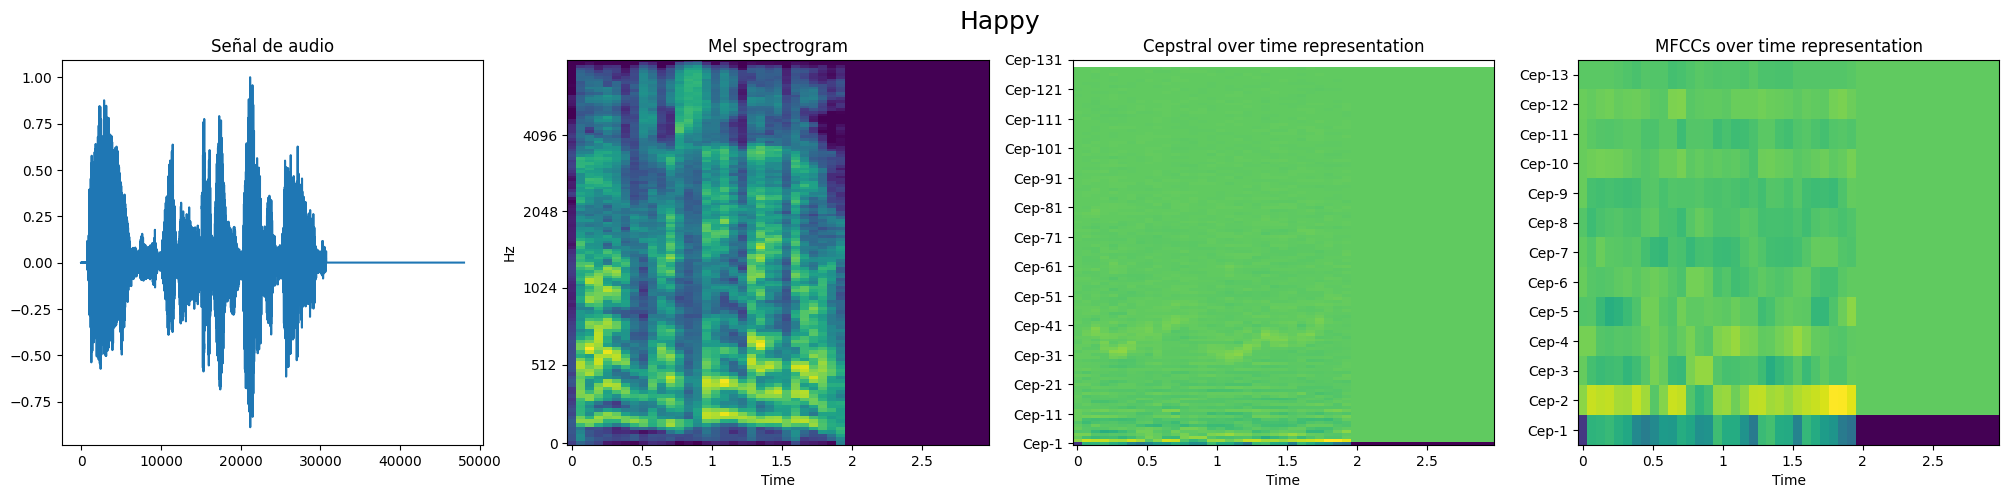

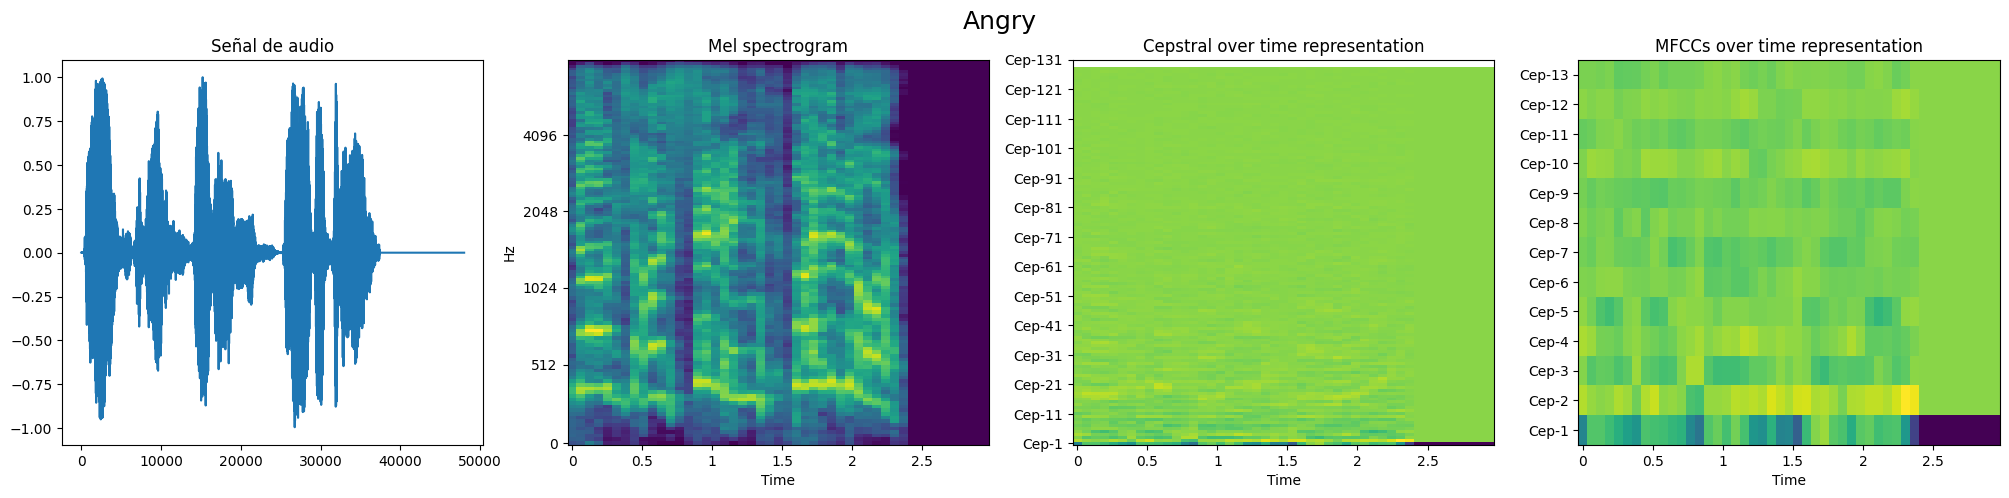

In [29]:
PATH_PRE = 'Data/'

NFFT = 2048
hop_length = NFFT//2
n_mels = 128
n_mfccs = 13

for i,clase in enumerate(os.listdir(PATH_PRE)):
    folder = os.path.join(PATH_PRE, clase)
    try:
      file = os.listdir(folder)[0]
      x, fs = librosa.load(os.path.join(folder, file), sr=16000)
      plot_mfccs_process(x, fs, NFFT, hop_length, n_mels, n_mfccs)
    except:
      None

En el ejemplo anterior calculamos un vector de MFCCs para cada ventana temporal del audio.
Para obtener una única representación por señal, podemos calcular el promedio de cada coeficiente a lo largo de todas las ventanas.
De esta manera, cada audio queda representado por un vector de 13 dimensiones, donde cada componente resume el comportamiento promedio de un coeficiente cepstral.

Esto significa que cada grabación puede considerarse como un punto en un espacio de 13 dimensiones.
Como no es posible visualizar directamente un espacio de esa dimensionalidad, graficaremos estos puntos en un plano bidimensional, utilizando los dos primeros coeficientes de cada audio para explorar cómo se agrupan las diferentes emociones.

In [30]:
NFFT = 2048
features_DB = []
labels_DB = []
audios_list = []
for i,clase in enumerate(os.listdir(PATH_PRE)):
    folder = os.path.join(PATH_PRE, clase)
    for file in os.listdir(folder):
        audios_list.append(folder + file)
        x, fs = librosa.load(os.path.join(folder, file), sr=16000)
        mfccs = np.mean(librosa.feature.mfcc(y=x, sr=fs, n_fft = NFFT, hop_length = NFFT//2, n_mfcc = 13, n_mels = 128),axis = 1)
        features_DB.append(mfccs)
        labels_DB.append(i)

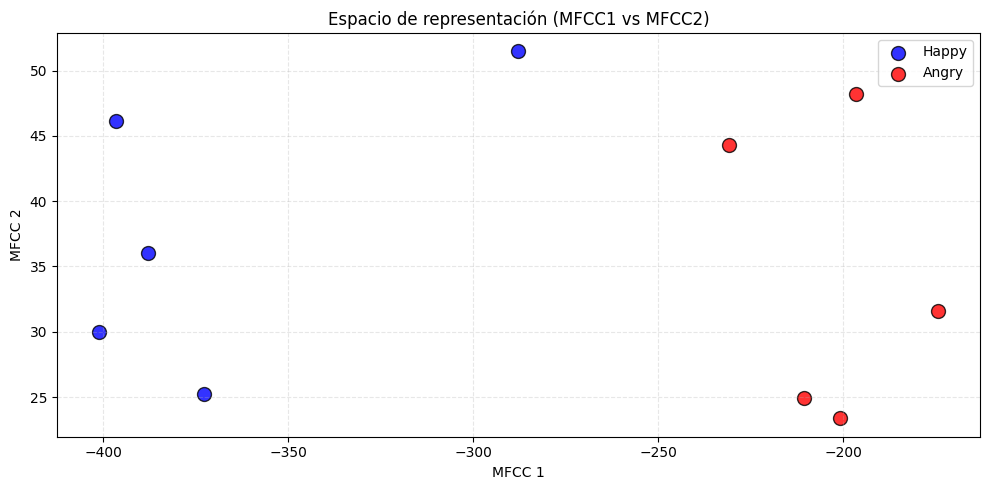

In [31]:
feat = np.asarray(features_DB)
plt.figure(figsize = (10,5))
#plt.scatter(feat[:,0], feat[:,1], c = labels_DB, s=100, alpha=0.7, edgecolors='k', cmap='coolwarm', label = labels_DB)


for label in set(labels_DB):

    idx_label = np.where(np.asarray(labels_DB)==label)
    feat_label = feat[idx_label]

    if label == 0:

        plt.scatter(feat_label[:,0], feat_label[:,1],
                    c='blue', s=100, alpha=0.8,
                    edgecolors='k', label='Happy')
    else:
        plt.scatter(feat_label[:,0], feat_label[:,1],
                    c='red', s=100, alpha=0.8,
                    edgecolors='k', label='Angry')

plt.xlabel("MFCC 1")
plt.ylabel("MFCC 2")
plt.title("Espacio de representación (MFCC1 vs MFCC2)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.legend()
#for i in range(feat.shape[0]):
#    plt.text(feat[i,0] + 0.005, feat[i,1] + 0.005, str(i), fontsize=9, color="black")

En la figura anterior se muestra cada audio representado por sus dos primeros coeficientes MFCC, lo que permite visualizar cómo las distintas emociones ocupan regiones diferentes dentro del espacio.
Aunque esta es una proyección muy simplificada (solo dos de los trece coeficientes), puede observarse una separación parcial entre las clases: los audios de felicidad tienden a agruparse en una zona distinta a los de enojo.
Esto ocurre porque se seleccionaron ejemplos que facilitan visualizar este comportamiento. ¿Qué ocurre si vemos el espacio de representación con todos los auidos de cada emoción?

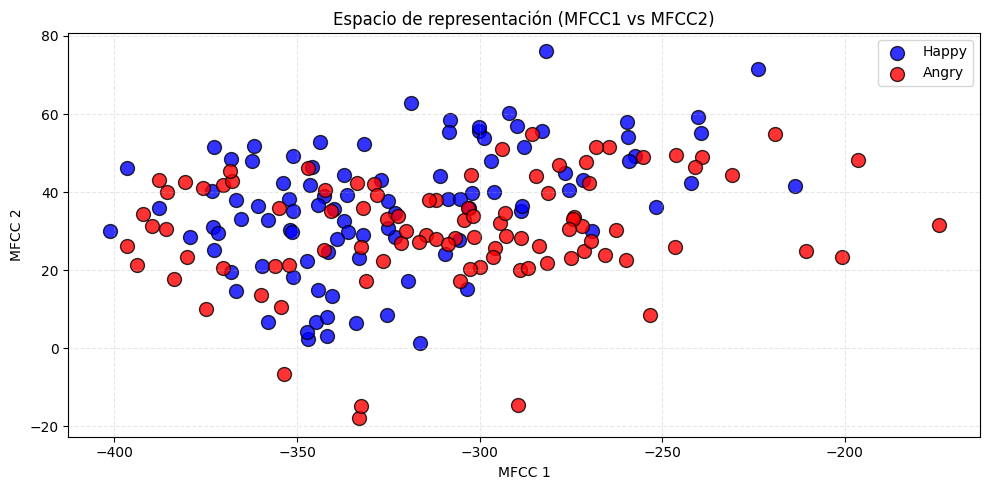

In [32]:
PATH_PRE = 'Emotion_DB_Complete/'
NFFT = 2048
features_DB = []
labels_DB = []
audios_list = []
for i,clase in enumerate(os.listdir(PATH_PRE)):
    folder = os.path.join(PATH_PRE, clase)
    for file in os.listdir(folder):
        audios_list.append(folder + file)
        x, fs = librosa.load(os.path.join(folder, file), sr=16000)
        mfccs = np.mean(librosa.feature.mfcc(y=x, sr=fs, n_fft = NFFT, hop_length = NFFT//2, n_mfcc = 13, n_mels = 128),axis = 1)
        features_DB.append(mfccs)
        labels_DB.append(i)

feat = np.asarray(features_DB)
plt.figure(figsize = (10,5))
#plt.scatter(feat[:,0], feat[:,1], c = labels_DB, s=100, alpha=0.7, edgecolors='k', cmap='coolwarm', label = labels_DB)


for label in set(labels_DB):

    idx_label = np.where(np.asarray(labels_DB)==label)
    feat_label = feat[idx_label]

    if label == 0:

        plt.scatter(feat_label[:,0], feat_label[:,1],
                    c='blue', s=100, alpha=0.8,
                    edgecolors='k', label='Happy')
    else:
        plt.scatter(feat_label[:,0], feat_label[:,1],
                    c='red', s=100, alpha=0.8,
                    edgecolors='k', label='Angry')

plt.xlabel("MFCC 1")
plt.ylabel("MFCC 2")
plt.title("Espacio de representación (MFCC1 vs MFCC2)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.legend()

Al incluir todos los audios de ambas clases, obtenemos una nube de puntos más dispersa, donde no existe una región claramente dominada por una sola emoción.
Esto se debe a que el espacio de representación es demasiado simple para capturar todas las variaciones de timbre, energía y entonación presentes en las voces.

Para lograr una separación más efectiva entre las emociones, es necesario utilizar un espacio de mayor dimensionalidad, por ejemplo, el espacio completo de 13 coeficientes MFCC, donde se preserva mucha más información acústica relevante para distinguir entre estados emocionales.

En está guía observamos cómo una señal de voz puede transformarse desde el dominio temporal hasta un espacio de representación acústico, donde sus características más relevantes se vuelven explícitas y útiles para el análisis.
A través de los MFCCs, logramos condensar la información espectral y perceptual de cada audio en un conjunto reducido de coeficientes que reflejan diferencias emocionales entre voces felices y enojadas.
Si bien en espacios de baja dimensionalidad la separación entre clases es limitada, en espacios más complejos estas representaciones permiten distinguir patrones con mayor claridad.
Este enfoque ilustra el poder de los espacios de representación: transformar señales crudas en representaciones vectoriales que mantienen la información relevante para discriminar dos conjuntos de auidos. Esto abre el camino hacia aplicaciones más avanzadas como el reconocimiento automático de voz, emociones y hablantes.